# ABOUT THIS NOTEBOOK
## Purpose
This notebook performs residual analysis for the various machine learning models attempted on the data set.    
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of residual analysis.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Implement classes & functions for common tasks
    * Fit the algorithm
    * Generate error column
    * Generate residual plot
* Run the following algorithms:
    * Random Forest Regressor
    * K Nearest Neighbors
    * Support Vector Machines
    * Linear Regression
    * Gradient Boosting Regressor
    * Neural Networks

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import re
import timeit

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.contrib.learn as skflow

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, tensorflow, sklearn & six'

Read in packages from os, numpy, pandas, matplotlib, seaborn, tensorflow, sklearn & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [4]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 55) (66528, 55) 




## Generate scaled features for train & test sets

In [5]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

# IMPLEMENT CLASSES & FUNCTIONS FOR COMMON TASKS

In [48]:
class ResidualPlot(object):
    '''Residual analysis for attempted machine learning algorithms'''
    
    def __init__(self,alg,X,y):
        '''Fit the algorithm to the test data'''
        self.reg = alg.fit(X,y)
        print 'Successfully fit the algorithm to train data.'
        
        self.pred_train = target_scaler.inverse_transform(self.reg.predict(X))
        self.error_train = X_train['gap'] - self.pred_train
        print 'Generated predictions and errors for train data.'
        
        self.residual_df = X_train.copy()
        self.residual_df['residual'] = self.error_train
        print 'Created dataframe with residual column.\n'
    
    def generate_resplot(self):
        '''Generate residual plot'''
        pdata_set = self.residual_df
        plot_set = pdata_set[(pdata_set['district_id'].isin([23]))]
        corrplot = plot_set[['residual', 'gap', 'demand_t-1', 'supply_t-1', 'tj_lvl3', 'time_slot', 'poi_pc1', 
                             'pollution', 'temperature']]
        
        
        sel_cols = ['gap', 'demand_t-1', 'supply_t-1', 'tj_lvl3', 'time_slot', 'poi_pc1', 'pollution', 'temperature']
        
        for col in sel_cols:
            curr_plot = corrplot[['residual', col]]

            curr_plot.plot.scatter(corrplot[col], corrplot['residual'])
        
        #corrplot.plot.scatter()
        #g = sns.PairGrid(corrplot)
        #g = g.map_upper(plt.scatter)
        #g = g.map_lower(plt.scatter)
        #g = g.map_diag(sns.kdeplot, lw=3, legend=False)
    
    def generate_corrmatrix(self):
        '''Generate correlation matrix with residual data'''
        print self.residual_df.corr()['residual']

# RANDOM FORESTS

Successfully fit the algorithm to train data.
Generated predictions and errors for train data.
Created dataframe with residual column.
district_id   -0.001942
num_day       -0.008025
time_slot     -0.021385
week_day      -0.002385
demand         0.177255
demand_t-1     0.053139
demand_t-2     0.011125
demand_t-3    -0.013909
supply        -0.000739
supply_t-1     0.001813
supply_t-2     0.006543
supply_t-3     0.008892
gap            0.397815
weather        0.005166
temperature   -0.006229
pollution      0.006328
poi_pc1       -0.017189
poi_pc2        0.006091
poi_pc3        0.001310
poi_pc4        0.010755
poi_cluster    0.005738
tj_lvl1        0.010142
tj_lvl2        0.004598
tj_lvl3        0.008162
tj_lvl4        0.008343
residual       1.000000
Name: residual, dtype: float64


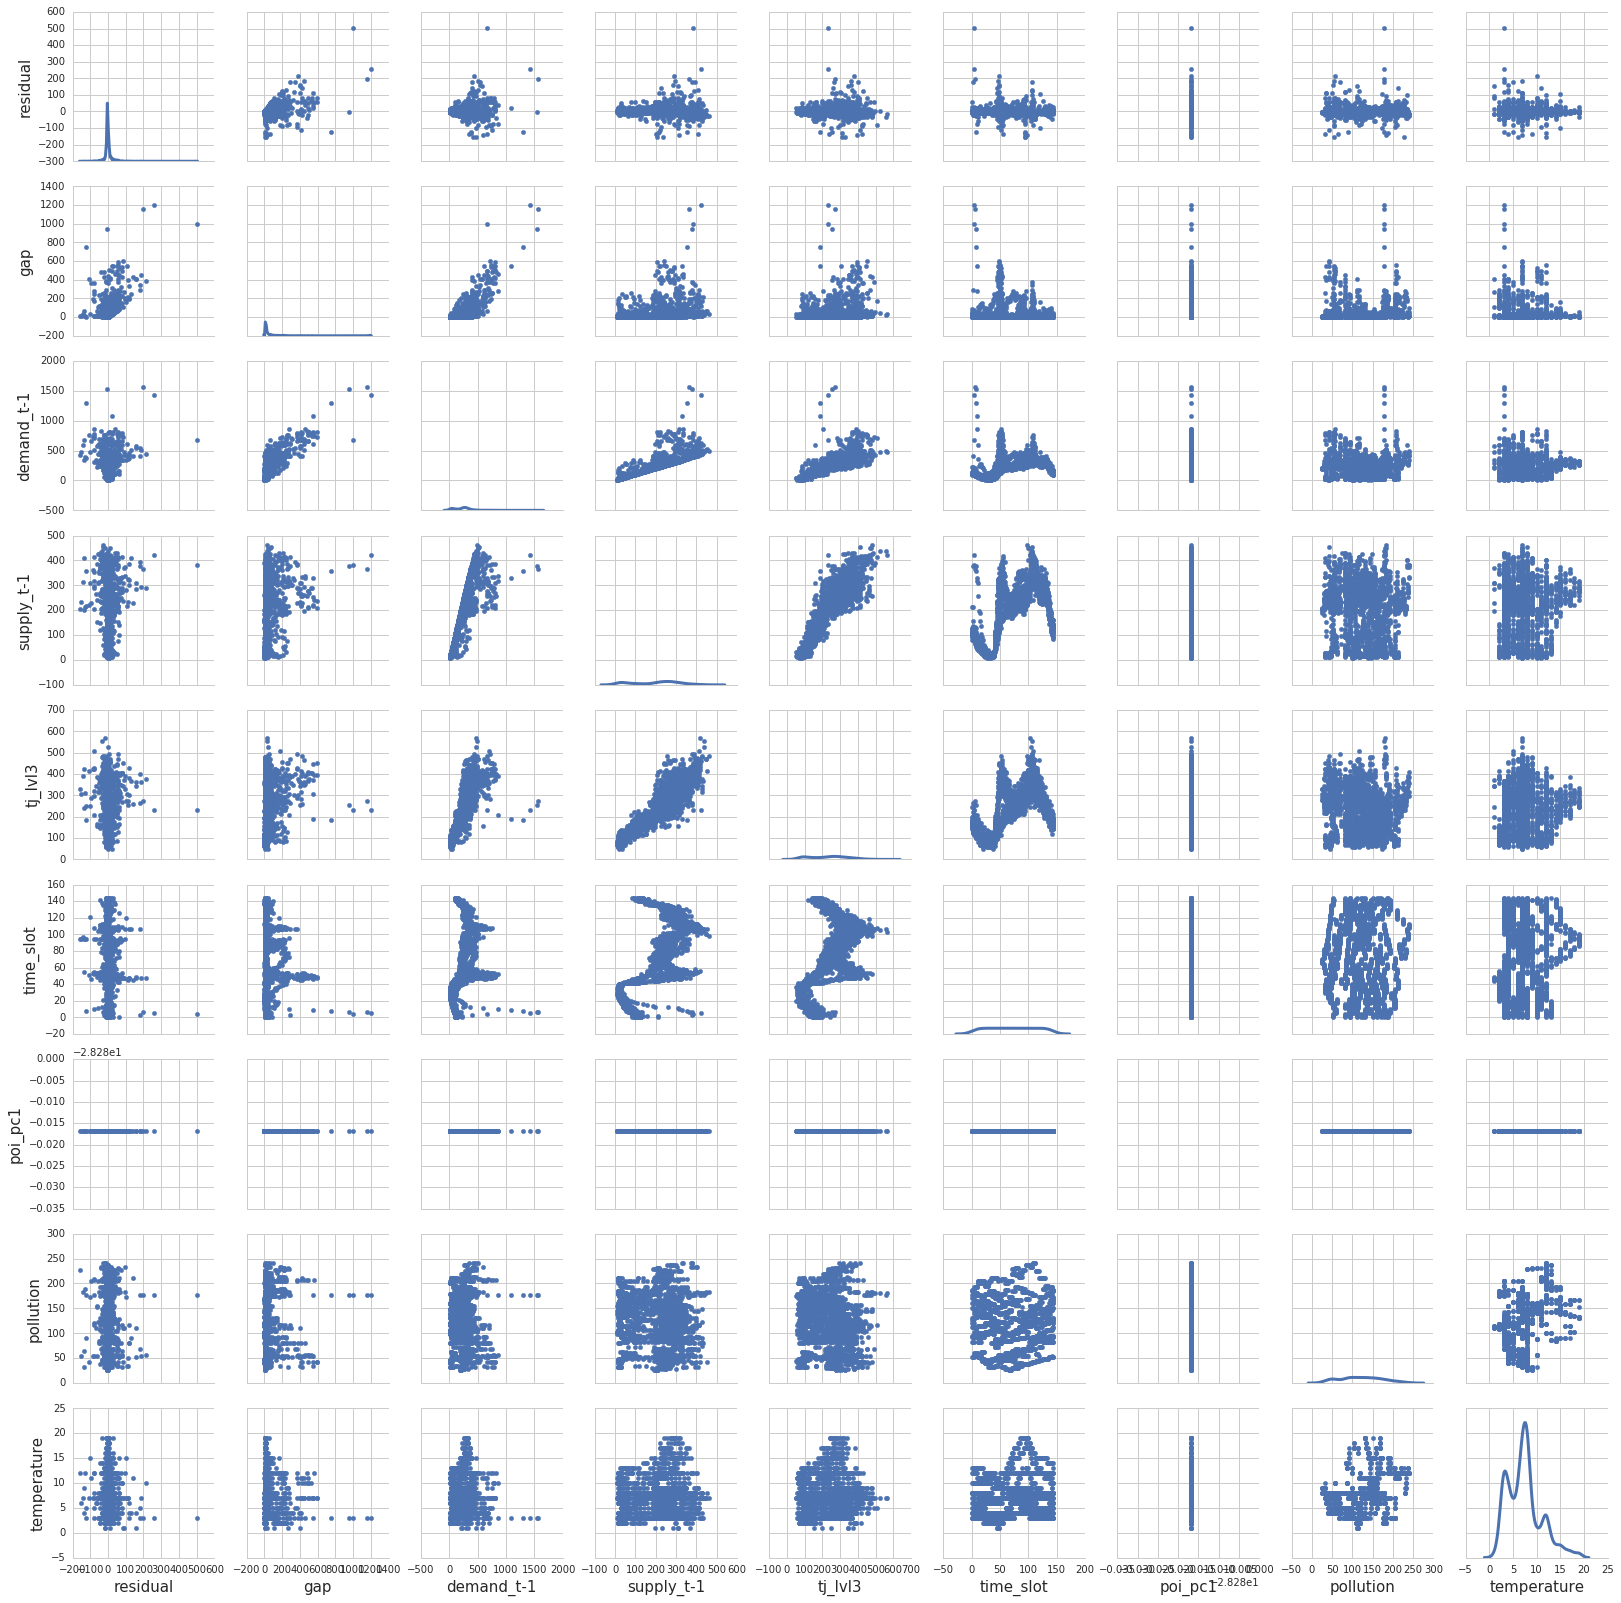

In [40]:
rf_predictors = [0,3,1,5,2,8,4,19]
alg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12, max_features=1.0, max_leaf_nodes=None, 
                            min_samples_leaf=5, min_samples_split=25, min_weight_fraction_leaf=0.0, n_estimators=300, 
                            n_jobs=-1, oob_score=False, random_state=0, verbose=0, warm_start=False
                           )

random_forests_residual = ResidualPlot(alg, gX_train[:, rf_predictors], gy_train)
random_forests_residual.generate_corrmatrix()
random_forests_residual.generate_resplot()

# K NEAREST NEIGHBORS

In [32]:
knn_predictors = [0,3,1,5,2,8,4,19]
alg_knn = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
          weights='uniform')

Successfully fit the algorithm to train data.
Generated predictions and errors for train data.
Created dataframe with residual column.

district_id    0.007680
num_day       -0.005703
time_slot     -0.023438
week_day      -0.007230
demand         0.135206
demand_t-1    -0.000137
demand_t-2    -0.000137
demand_t-3    -0.000136
supply        -0.009839
supply_t-1    -0.000102
supply_t-2    -0.000101
supply_t-3    -0.000101
gap            0.318867
weather        0.004332
temperature   -0.012485
pollution      0.000221
poi_pc1       -0.011284
poi_pc2        0.021557
poi_pc3       -0.007458
poi_pc4        0.012480
poi_cluster    0.005021
tj_lvl1       -0.000020
tj_lvl2       -0.006764
tj_lvl3       -0.005357
tj_lvl4       -0.005469
residual       1.000000
Name: residual, dtype: float64


IndexError: indices are out-of-bounds

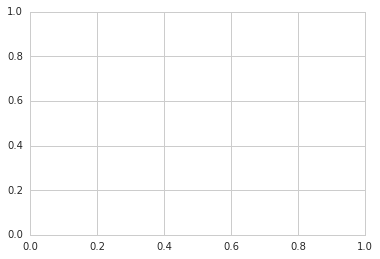

In [49]:
linear_predictors = [0,3,2,4]
alg = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

linear_regr_residual = ResidualPlot(alg, gX_train[:, rf_predictors], gy_train)
linear_regr_residual.generate_corrmatrix()
linear_regr_residual.generate_resplot()

GridSearchCV Runtime: 0h:00m:12s


All CV Scores: [ 0.79856636  0.77742912  0.72768037  0.55447625 -0.3710584 ]
Mean CV Score: 0.497 +/- 0.443
Best Estimator:
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
Learning Curves Runtime: 0h:00m:22s


Train Size:    1064 Train Score: 0.574 Test Score: 0.364
Train Size:   22140 Train Score: 0.782 Test Score: 0.708
Train Size:   43216 Train Score: 0.817 Test Score: 0.755
Train Size:   64292 Train Score: 0.853 Test Score: 0.789
Train Size:   85368 Train Score: 0.870 Test Score: 0.802
Train Size:  106444 Train Score: 0.878 Test Score: 0.813


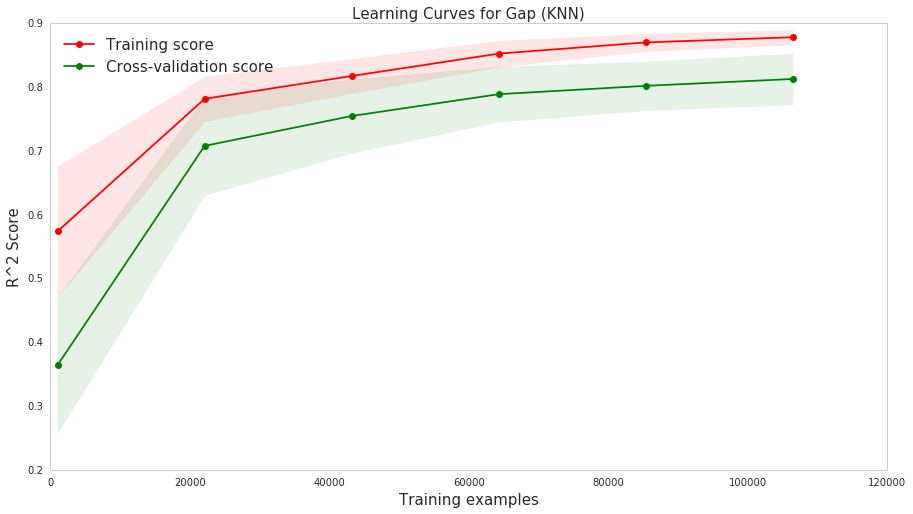



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	220.446		0.885		0.347
TEST      	405.398		0.825		0.419


In [37]:
# Specify parameters
param_grid = {'n_neighbors' : [5, 6, 7],
              'weights'     : ['uniform'],
              'metric'      : ['euclidean', 'minkowski']}

alg = KNeighborsRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, knn_predictors], gy_train=gy_train, gX_test=gX_test[:, knn_predictors], gy_test=gy_test,
                   alg=alg, alg_name='KNN', param_grid=param_grid, scoring_func='r2')

# SUPPORT VECTOR MACHINES

Based on the learning curve experiments, we conclude that the top 6 features are sufficient to capture most of the performance with SVM.

In [31]:
svm_predictors = [0,3,1,4,2,5]

GridSearchCV Runtime: 0h:15m:46s


All CV Scores: [ 0.86344628  0.84256625  0.8056179   0.90931007 -0.37709791]
Mean CV Score: 0.609 +/- 0.494
Best Estimator:
SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Learning Curves Runtime: 0h:06m:25s


Train Size:    1064 Train Score: 0.869 Test Score: 0.846
Train Size:   22140 Train Score: 0.888 Test Score: 0.869
Train Size:   43216 Train Score: 0.884 Test Score: 0.870
Train Size:   64292 Train Score: 0.889 Test Score: 0.870
Train Size:   85368 Train Score: 0.890 Test Score: 0.870
Train Size:  106444 Train Score: 0.890 Test Score: 0.870


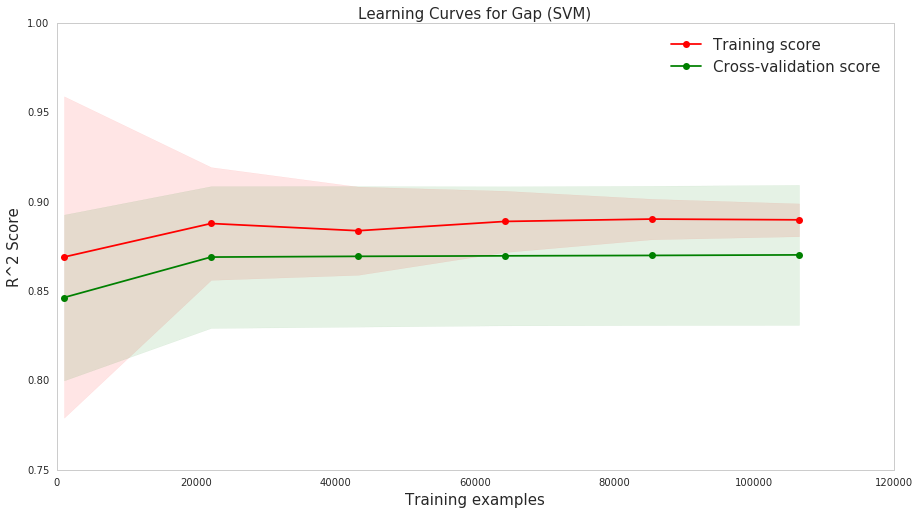



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	212.829		0.888		0.419
TEST      	301.117		0.870		0.412


In [32]:
# Specify parameters
param_grid = {'kernel'      : ['linear'],
              'C'           : [1.0],
              'epsilon'     : [0.1],
              'cache_size'  : [1000]  # to improve runtime
             }

alg = SVR()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, svm_predictors], gy_train=gy_train, gX_test=gX_test[:, svm_predictors], gy_test=gy_test,
                   alg=alg, alg_name='SVM', param_grid=param_grid, scoring_func='r2')

# LINEAR REGRESSION

Based on the learning curve experiments, we conclude that the top 4 features are sufficient to achieve the best performance with linear regression. The performance with just the top 4 features matches the results from using all the features.

In [19]:
linear_predictors = [0,3,2,4]
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

GridSearchCV Runtime: 0h:00m:04s


All CV Scores: [ 0.85669136  0.84451253  0.80138221  0.91703408 -0.55445102]
Mean CV Score: 0.573 +/- 0.565
Best Estimator:
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)
Learning Curves Runtime: 0h:00m:08s


Train Size:    1064 Train Score: 0.880 Test Score: 0.854
Train Size:   22140 Train Score: 0.894 Test Score: 0.871
Train Size:   43216 Train Score: 0.890 Test Score: 0.873
Train Size:   64292 Train Score: 0.895 Test Score: 0.874
Train Size:   85368 Train Score: 0.896 Test Score: 0.874
Train Size:  106444 Train Score: 0.895 Test Score: 0.874


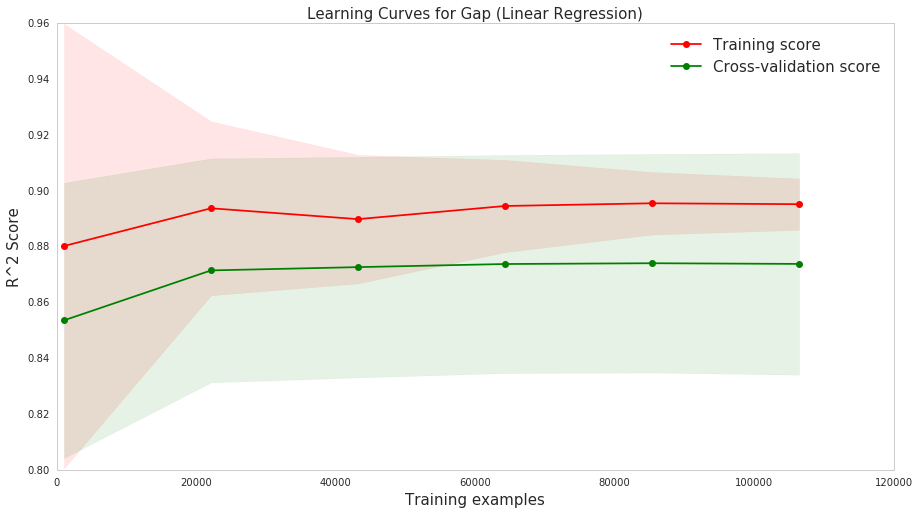



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	203.251		0.894		0.569
TEST      	299.985		0.870		0.546


In [21]:
# No parameters to select
param_grid = {'fit_intercept'   : [True, False],
              'normalize'       : [True, False]
             }

alg = LinearRegression()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, linear_predictors], gy_train=gy_train, gX_test=gX_test[:, linear_predictors], gy_test=gy_test,
                   alg=alg, alg_name='Linear Regression', param_grid=param_grid, scoring_func='r2')

# GRADIENT BOOSTED TREES

In [11]:
gbr_predictors = [0,3,2,1,20,9,5,19]

Based on the learning curve experiments, we conclude that the top 8 features are sufficient to capture most of the performance with gradient boosting. Increasing features beyond this level can result in overfitting.

GridSearchCV Runtime: 0h:01m:03s


All CV Scores: [ 0.83548705  0.84789108  0.77977224  0.53527624 -0.22552939]
Mean CV Score: 0.555 +/- 0.406
Best Estimator:
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.15, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=8,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)
Learning Curves Runtime: 0h:01m:18s


Train Size:    1064 Train Score: 0.992 Test Score: 0.220
Train Size:   22140 Train Score: 0.971 Test Score: 0.779
Train Size:   43216 Train Score: 0.966 Test Score: 0.831
Train Size:   64292 Train Score: 0.967 Test Score: 0.852
Train Size:   85368 Train Score: 0.963 Test Score: 0.862
Train Size:  106444 Train Score: 0.962 Test Score: 0.875


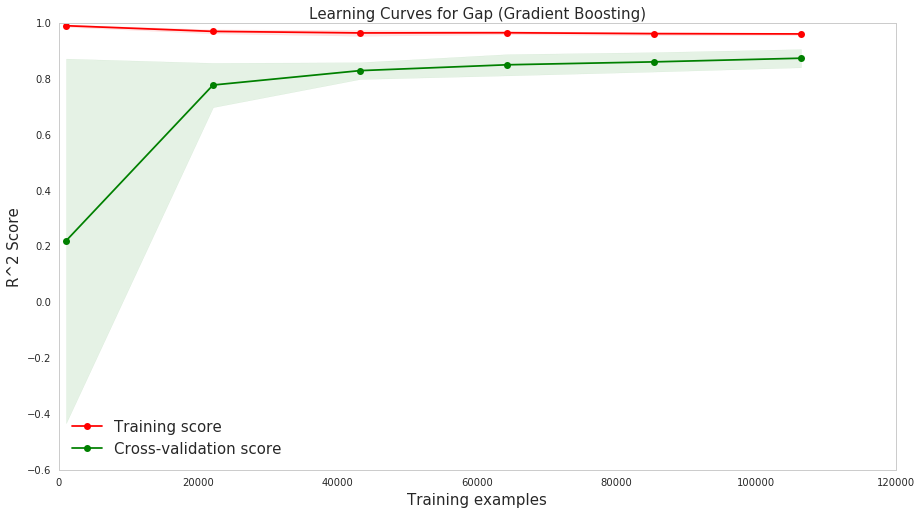



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	76.891		0.960		0.414
TEST      	389.059		0.832		0.481


In [30]:
# No parameters to select
param_grid = {'learning_rate'          : [0.15],
              'n_estimators'           : [100],
              'max_depth'              : [5],
              'min_samples_split'      : [7,8],
              'min_samples_leaf'       : [3],
              'subsample'              : [0.8]
             }

alg = GradientBoostingRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, gbr_predictors], gy_train=gy_train, gX_test=gX_test[:, gbr_predictors], 
                   gy_test=gy_test, alg=alg, alg_name='Gradient Boosting', param_grid=param_grid, scoring_func='r2')